In [39]:
import re
import joblib
import io
import shap
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import hf_xet


from tqdm import tqdm
from huggingface_hub import HfFolder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker


import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer   # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences   # type: ignore
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, LSTM     # type: ignore
from tensorflow.keras.callbacks import EarlyStopping     # type: ignore
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, BertForSequenceClassification

# Use Python APIs to clear Hugging Face cache (avoid shell magic which can be brittle in some environments)
import os
import shutil
hf_cache_home = os.getenv('HF_HOME', os.path.join(os.path.expanduser('~'), '.cache', 'huggingface'))
if os.path.exists(hf_cache_home):
    try:
        shutil.rmtree(hf_cache_home)
        print(f"Hugging Face cache cleared: {hf_cache_home}")
    except Exception as e:
        print(f"Failed to remove Hugging Face cache {hf_cache_home}: {e}")
else:
    print(f"Hugging Face cache directory not found: {hf_cache_home}")

# NLTK downloads (keep as-is). If you encounter errors here, run these individually in a cell.
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


Hugging Face cache cleared: C:\Users\ASUS\.cache\huggingface


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Dataset

In [12]:
df = pd.read_excel(r"D:\Backend\Elect-3-Machine-Learning-PIT\data\student_sentiments.xlsx")
print("Shape:", df.shape)
display(df.head())

Shape: (46546, 3)


,sents,sentiments,topics
0,Full course slides .,2,1
1,"Enthusiastic teaching, close to students.",2,0
2,Attend school with full marks for attendance.,0,1
3,have not yet applied information technology an...,0,0
4,"The teacher teaches well, there are many examp...",2,0


# Label Mapping

In [13]:
# ---- Auto-detect TEXT column ----
text_candidates = [
    c for c in df.columns
    if any(x in c.lower() for x in ['feedback', 'comment', 'text', 'review', 'sents', 'response'])
]

if not text_candidates:
    raise ValueError("No text column found. Please rename your text column to something like 'feedback' or 'comment'.")

text_col = text_candidates[0]

# ---- Auto-detect LABEL column ----
label_candidates = [
    c for c in df.columns
    if any(x in c.lower() for x in ['label', 'sentiment', 'rating', 'class'])
]

# fallback: find binary-like columns
if not label_candidates:
    for c in df.columns:
        if df[c].nunique() == 2 and c != text_col:
            label_candidates.append(c)

if not label_candidates:
    raise ValueError("No label/sentiment column found. Please rename your label column.")

label_col = label_candidates[0]

print(f"Detected text column: {text_col}")
print(f"Detected label column: {label_col}")

# ---- Build the cleaned df ----
df = df[[text_col, label_col]].rename(columns={
    text_col: "text",
    label_col: "original_label"
}).dropna().reset_index(drop=True)

# ---- Sample only 10000 rows ----
SAMPLE_N = 10000
if len(df) >= SAMPLE_N:
    df = df.sample(n=SAMPLE_N, random_state=42).reset_index(drop=True)

print("Sampled shape:", df.shape)

# ---- Label Mapping ----
def map_label(val):
    v = str(val).strip().lower()

    positive_words = ['positive', 'pos', 'p', '1', 'yes', 'y', 'good', 'happy']
    negative_words = ['negative', 'neg', 'n', '0', 'no', 'bad', 'angry']

    # String label mapping
    if v in positive_words:
        return 1
    if v in negative_words:
        return 0

    # Numeric label mapping
    if v.isdigit():
        num = int(v)
        if num == 1: return 1
        if num == 0: return 0
        if 1 <= num <= 5:
            return 1 if num >= 3 else 0

    # fallback
    return 1 if 'pos' in v or '1' in v else 0

df["label"] = df["original_label"].apply(map_label)

print("Label distribution:")
print(df["label"].value_counts())


Detected text column: sents
Detected label column: sentiments
Sampled shape: (10000, 2)
Label distribution:
label
0    6683
1    3317
Name: count, dtype: int64


# Data Cleaning

In [14]:
# === Preprocessing pipeline (cached spellchecker) ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
speaker = SpellChecker(distance=1)
spell_cache = {}

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # reduce repeated chars
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    tokens = word_tokenize(text)
    cleaned = []
    for t in tokens:
        if t in stop_words:
            continue
        if len(t) > 2:
            if t in spell_cache:
                t = spell_cache[t]
            else:
                corr = speaker.correction(t)
                if corr:
                    spell_cache[t] = corr
                    t = corr
        t = lemmatizer.lemmatize(t)
        cleaned.append(t)
    return " ".join(cleaned)

In [15]:
# Apply
df['clean_text'] = df['text'].astype(str).map(clean_text)
display(df[['clean_text']].head(8))

,clean_text
0,teach enthusiastically giving student access m...
1,system grading project according level closing...
2,although learning method acting quite effectiv...
3,although teacher small clear voice authority m...
4,classroom necessitate install fan socket stude...
5,necessary arrange classroom accordance number ...
6,classroom need install devotee socket educated...
7,1 give watch teaching say subject must laborat...


# Splitting

In [17]:
# === split into train/val/test (70/15/15 stratified) ===
X = df['clean_text'].values
y = df['label'].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
val_relative = 0.15 / (1 - 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_relative, random_state=42, stratify=y_train_val)
print("Sizes: train", len(X_train), "val", len(X_val), "test", len(X_test))

Sizes: train 7000 val 1500 test 1500


# Feature Extraction BOW and TFIDF

### BOW

In [19]:
bow = CountVectorizer(ngram_range=(1,1), max_features=5000)

X_train_bow = bow.fit_transform(X_train)
X_val_bow = bow.transform(X_val)
X_test_bow = bow.transform(X_test)

corpus = df['clean_text'].fillna('').tolist()
X_counts = bow.fit_transform(corpus)  # sparse matrix (n_docs x n_features)
print("BoW shape:", X_counts.shape)

# Convert to DataFrame (feature names as columns)
bow_df = pd.DataFrame(X_counts.toarray(), columns=bow.get_feature_names_out())
bow_df.index = df.index  # align indices with original df
bow_df.head()

BoW shape: (10000, 3217)


,00,10,10th,11,13h00,13h30,140,14h00,15,16,...,wzjwz78,wzjwz81,wzjwz82,wzjwz97,year,yell,yes,yet,young,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF

In [20]:
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

X_tfidf = tfidf.fit_transform(corpus)
print("TF-IDF shape:", X_tfidf.shape)

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.index = df.index
tfidf_df.head()

TF-IDF shape: (10000, 3217)


,00,10,10th,11,13h00,13h30,140,14h00,15,16,...,wzjwz78,wzjwz81,wzjwz82,wzjwz97,year,yell,yes,yet,young,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train Classical Models and Evaluate

In [21]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVC": LinearSVC(max_iter=10000),
    "MultinomialNB": MultinomialNB(),
    "RidgeClassifier": RidgeClassifier(),
    "PassiveAggressive": PassiveAggressiveClassifier(max_iter=1000)
}

results = []
def evaluate(name, model, Xtr, Xv, ytr, yv):
    model.fit(Xtr, ytr)
    preds = model.predict(Xv)
    acc = accuracy_score(yv, preds)
    prec = precision_score(yv, preds, zero_division=0)
    rec = recall_score(yv, preds, zero_division=0)
    f1 = f1_score(yv, preds, zero_division=0)
    cm = confusion_matrix(yv, preds)
    print(f"\n{name}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")
    print("confusion:\n", cm)
    print(classification_report(yv, preds, zero_division=0))
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'cm': cm})

print("=== TF-IDF models ===")
for n,m in models.items():
    evaluate(n + " (tfidf)", m, X_train_tfidf, X_val_tfidf, y_train, y_val)

print("\n=== BoW models ===")
for n,m in models.items():
    # reinstantiate to avoid warm state issues
    if n=="LogisticRegression": mm=LogisticRegression(max_iter=1000)
    elif n=="LinearSVC": mm=LinearSVC(max_iter=10000)
    elif n=="MultinomialNB": mm=MultinomialNB()
    elif n=="RidgeClassifier": mm=RidgeClassifier()
    else: mm=PassiveAggressiveClassifier(max_iter=1000)
    evaluate(n + " (bow)", mm, X_train_bow, X_val_bow, y_train, y_val)

=== TF-IDF models ===

LogisticRegression (tfidf): acc=0.9853, prec=0.9897, rec=0.9658, f1=0.9776
confusion:
 [[998   5]
 [ 17 480]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1003
           1       0.99      0.97      0.98       497

    accuracy                           0.99      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500


LinearSVC (tfidf): acc=0.9860, prec=0.9877, rec=0.9698, f1=0.9787
confusion:
 [[997   6]
 [ 15 482]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1003
           1       0.99      0.97      0.98       497

    accuracy                           0.99      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500


MultinomialNB (tfidf): acc=0.9813, prec=0.9737, rec=0.9698, f1=0.9718
confusion:
 [[990  13]
 [ 15 482]]
     

d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1003
           1       0.98      0.97      0.97       497

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500


=== BoW models ===

LogisticRegression (bow): acc=0.9853, prec=0.9877, rec=0.9678, f1=0.9776
confusion:
 [[997   6]
 [ 16 481]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1003
           1       0.99      0.97      0.98       497

    accuracy                           0.99      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500


LinearSVC (bow): acc=0.9840, prec=0.9817, rec=0.9698, f1=0.9757
confusion:
 [[994   9]
 [ 15 482]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1003
        

## Picking the Best Model

Best on validation (tfidf): LinearSVC (tfidf)
Saved artifacts to ./models/
Final test metrics:
Accuracy: 0.9806666666666667
Precision: 0.9855072463768116
Recall: 0.9558232931726908
F1: 0.9704383282364933
Confusion matrix:
 [[995   7]
 [ 22 476]]


d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


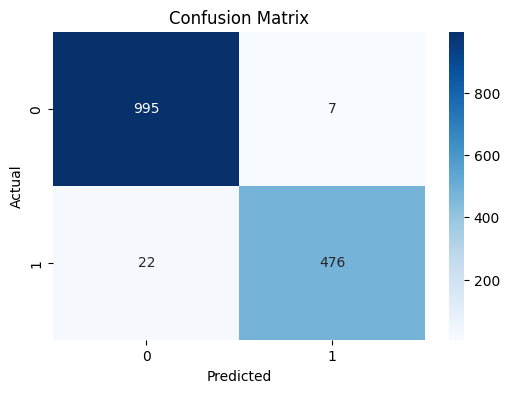

In [22]:
# === pick best TF-IDF model by F1, retrain on train+val, evaluate on test & save artifacts ===
tfidf_results = [r for r in results if '(tfidf)' in r['model']]
best = sorted(tfidf_results, key=lambda x: x['f1'], reverse=True)[0]
print("Best on validation (tfidf):", best['model'])

best_short = best['model'].split()[0]
if best_short == "LogisticRegression":
    final_model = LogisticRegression(max_iter=1000)
elif best_short == "LinearSVC":
    final_model = LinearSVC(max_iter=10000)
elif best_short == "MultinomialNB":
    final_model = MultinomialNB()
elif best_short == "RidgeClassifier":
    final_model = RidgeClassifier()
else:
    final_model = PassiveAggressiveClassifier(max_iter=1000)

from scipy.sparse import vstack
X_train_val_tfidf = vstack([X_train_tfidf, X_val_tfidf])
y_train_val = np.concatenate([y_train, y_val])
final_model.fit(X_train_val_tfidf, y_train_val)
test_preds = final_model.predict(X_test_tfidf)


# Save vectorizers and model (joblib)
os.makedirs('./models', exist_ok=True)
joblib.dump(tfidf, './models/tfidf_vectorizer.joblib')
joblib.dump(bow, './models/bow_vectorizer.joblib')
joblib.dump(final_model, './models/final_model.joblib')
print("Saved artifacts to ./models/")

print("Final test metrics:")
print("Accuracy:", accuracy_score(y_test, test_preds))
print("Precision:", precision_score(y_test, test_preds, zero_division=0))
print("Recall:", recall_score(y_test, test_preds, zero_division=0))
print("F1:", f1_score(y_test, test_preds, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, test_preds))
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Deep Learning

In [23]:
# PREP TEXT FOR DEEP LEARNING

MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
# use the already-defined train/val arrays (clean text) named X_train and X_val
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')

### CNN Model

In [24]:
#Training CNN

cnn_model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPool1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

cnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
110/110 [==============================] - 5s 41ms/step - loss: 0.2550 - accuracy: 0.8949 - val_loss: 0.0565 - val_accuracy: 0.9827
Epoch 2/10
110/110 [==============================] - 4s 38ms/step - loss: 0.0460 - accuracy: 0.9860 - val_loss: 0.0524 - val_accuracy: 0.9847
Epoch 3/10
110/110 [==============================] - 4s 37ms/step - loss: 0.0282 - accuracy: 0.9904 - val_loss: 0.0586 - val_accuracy: 0.9860
Epoch 4/10
110/110 [==============================] - 4s 38ms/step - loss: 0.0181 - accuracy: 0.9939 - val_loss: 0.0745 - val_accuracy: 0.9747
Epoch 5/10
110/110 [==============================] - 4s 38ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 0.0719 - val_accuracy: 0.9807
Epoch 6/10
110/110 [==============================] - 4s 39ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0822 - val_accuracy: 0.9813
Epoch 7/10
110/110 [==============================] - 4s 38ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0958 - val_accuracy: 0.9780

47/47 [==============================] - 0s 6ms/step

📌 CNN Classification Report
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99      1002
    Positive       0.99      0.96      0.97       498

    accuracy                           0.98      1500
   macro avg       0.98      0.97      0.98      1500
weighted avg       0.98      0.98      0.98      1500


📌 Confusion Matrix:
[[995   7]
 [ 22 476]]


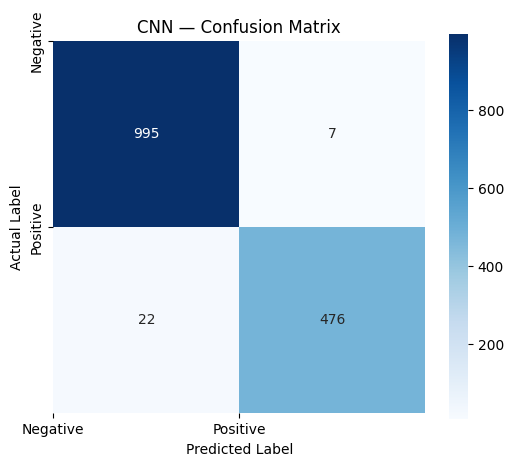

In [25]:
# Prepare test set for CNN (if not already done)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, padding='post')

# Predict probabilities for test set
y_pred_bin_probs = cnn_model.predict(X_test_pad)
# Convert probabilities to binary predictions (threshold 0.5)
y_pred_bin = (y_pred_bin_probs > 0.5).astype(int).flatten()

print("\n📌 CNN Classification Report")
print(classification_report(y_test, y_pred_bin, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_test, y_pred_bin)
print("\n📌 Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("CNN — Confusion Matrix")

classes = ["Negative", "Positive"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()

# Training New Models

## LSTM Model

In [26]:
# Training LSTM
lstm_model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
110/110 [==============================] - 19s 158ms/step - loss: 0.6450 - accuracy: 0.6676 - val_loss: 0.6358 - val_accuracy: 0.6687
Epoch 2/10
110/110 [==============================] - 19s 171ms/step - loss: 0.6379 - accuracy: 0.6683 - val_loss: 0.6353 - val_accuracy: 0.6687
Epoch 3/10
110/110 [==============================] - 20s 179ms/step - loss: 0.6392 - accuracy: 0.6683 - val_loss: 0.6357 - val_accuracy: 0.6687
Epoch 4/10
110/110 [==============================] - 20s 178ms/step - loss: 0.6397 - accuracy: 0.6683 - val_loss: 0.6351 - val_accuracy: 0.6687
Epoch 5/10
110/110 [==============================] - 19s 174ms/step - loss: 0.6380 - accuracy: 0.6683 - val_loss: 0.6356 - val_accuracy: 0.6687
Epoch 6/10
110/110 [==============================] - 19s 175ms/step - loss: 0.6386 - accuracy: 0.6683 - val_loss: 0.6360 - val_accuracy: 0.6687
Epoch 7/10
110/110 [==============================] - 19s 172ms/step - loss: 0.6385 - accuracy: 0.6683 - val_loss: 0.6353 - val_ac

47/47 [==============================] - 1s 22ms/step

📌 LATM Classification Report
              precision    recall  f1-score   support

    Negative       0.67      1.00      0.80      1002
    Positive       0.00      0.00      0.00       498

    accuracy                           0.67      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.45      0.67      0.54      1500


📌 Confusion Matrix:
[[1002    0]
 [ 498    0]]


d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

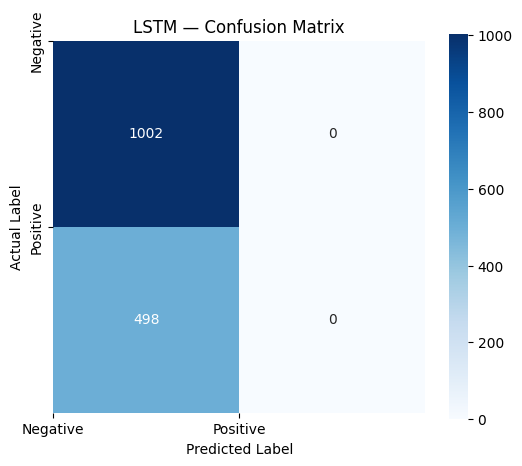

In [27]:
# Prepare test set for LSTM (if not already done)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, padding='post')

# Predict probabilities for test set
y_pred_bin_probs = lstm_model.predict(X_test_pad)
# Convert probabilities to binary predictions (threshold 0.5)
y_pred_bin = (y_pred_bin_probs > 0.5).astype(int).flatten()

print("\n📌 LATM Classification Report")
print(classification_report(y_test, y_pred_bin, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_test, y_pred_bin)
print("\n📌 Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("LSTM — Confusion Matrix")

classes = ["Negative", "Positive"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()

## DistilBERT Model

In [50]:
# Training DistilBERT (huggingface + tensorflow)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_enc = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_enc = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)

# Explicitly convert labels to tf.int32 to ensure compatibility with SparseCategoricalCrossentropy
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_enc), tf.convert_to_tensor(y_train, dtype=tf.int32))).shuffle(1000).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_enc), tf.convert_to_tensor(y_val, dtype=tf.int32))).batch(16)

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, use_safetensors=False)
optimizer = tf.optimizers.Adam(learning_rate=3e-5)

# Explicitly define the loss function, typically SparseCategoricalCrossentropy for 2-class logits with integer labels
def compute_custom_loss(labels, logits):
    return loss_fn(labels, logits)

model.compile(optimizer=optimizer, loss=compute_custom_loss, metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_201', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/3


AttributeError: in user code:

    File "d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "d:\Backend\Elect-3-Machine-Learning-PIT\.venv\lib\site-packages\transformers\modeling_tf_utils.py", line 1614, in train_step
        # Newer TF train steps leave this out

    AttributeError: module 'keras.utils' has no attribute 'unpack_x_y_sample_weight'


In [ ]:
# ----- GET PREDICTIONS -----
pred_output = model.predict(val_dataset)

# Convert logits → probabilities → class labels (0 = Negative, 1 = Positive)
y_pred = np.argmax(pred_output.logits, axis=1)

# ----- GET TRUE LABELS -----
y_true = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

# ----- CLASSIFICATION REPORT (ALIGNED TO CNN/LSTM) -----
print("\n📊 DISTILBERT CLASSIFICATION REPORT (ALIGNED)\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Negative", "Positive"],
    digits=4
))

# ----- CONFUSION MATRIX -----
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

print("\n📌 CONFUSION MATRIX (Numeric):\n")
print(cm)

classes = ["Negative", "Positive"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


plt.title("DistilBERT Confusion Matrix")
plt.grid(False)
plt.show()

## XAI SHAP on Classical Model

## XAI SHAP on Deep Learning

### LSTM

In [41]:
# Re-initialize the Keras Tokenizer for LSTM SHAP explanation
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

# 1. Wrapper: SHAP receives raw text → we tokenize inside predict_fn
def predict_fn(text_list):
    seqs = tokenizer.texts_to_sequences(text_list)
    pads = pad_sequences(seqs, maxlen=MAX_LEN, padding='post')
    probs = lstm_model.predict(pads)
    # Ensure output is (num_samples, 2) for binary classification (prob_neg, prob_pos)
    return np.hstack([1 - probs, probs])

# Define a simple word tokenizer function for SHAP masker
def shap_word_tokenizer(text):
    return nltk.word_tokenize(text)

In [42]:
# Background text (SHAP requirement)
background_texts = df['text'].sample(30, random_state=42).tolist()

In [43]:
# create explainer with Text masker — pass the masker object, don't call it
explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer=None))

In [44]:
# explain a few examples (pass raw text strings)
sample_texts = df['text'].iloc[:5].tolist()
# Calculate SHAP values
shap_values = explainer(sample_texts)

# Plot
shap.plots.text(shap_values[0])

1/1 [==============================] - 0s 168ms/step


PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer:  60%|██████    | 3/5 [00:27<00:08,  4.40s/it]

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer:  80%|████████  | 4/5 [00:35<00:05,  5.75s/it]

1/1 [==============================] - 0s 46ms/step


PartitionExplainer explainer: 100%|██████████| 5/5 [00:39<00:00,  5.04s/it]

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 33ms/step


PartitionExplainer explainer: 6it [00:46,  9.39s/it]                       


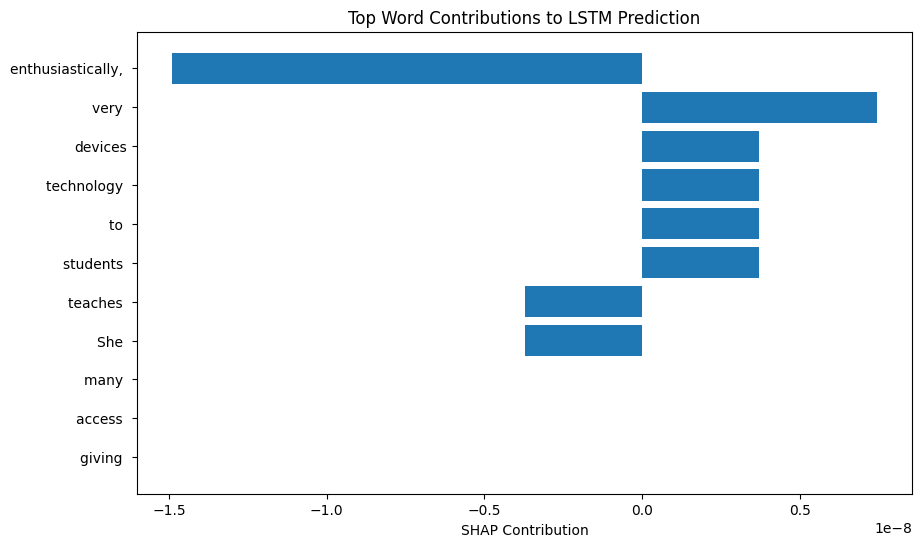

In [45]:
#EVALUATING XAI SHAP LSTM
vals = shap_values.values[0] # Assuming shap_values[0] is the explanation for the first sample_text

# Auto-extract correct SHAP shape
if vals.ndim == 1:
    word_shap = vals
elif vals.ndim == 2:
    # shape (tokens, outputs)
    word_shap = vals[:, 1]          # positive class
elif vals.ndim == 3:
    # shape (tokens, outputs, ???)
    word_shap = vals[:, 1, -1]      # pick last dimension for class 1
else:
    raise ValueError("Unexpected SHAP shape: " + str(vals.shape))

# Get tokens
tokens = shap_values.data[0]

# Remove empty tokens
valid = [k for k,w in enumerate(tokens) if w.strip() != ""]
word_shap = np.array([word_shap[k] for k in valid])
tokens = np.array([tokens[k] for k in valid])

# Top-N
N = 15
idx = np.argsort(np.abs(word_shap))[::-1][:N]

top_tokens = tokens[idx]
top_scores = word_shap[idx]

# Plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
ypos = np.arange(len(top_tokens))
plt.barh(ypos, top_scores)
plt.yticks(ypos, top_tokens)
plt.xlabel("SHAP Contribution")
plt.title("Top Word Contributions to LSTM Prediction")
plt.gca().invert_yaxis()
plt.show()

### DistilBERT

In [46]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Wrap model to probability output (using TensorFlow)
def predict_proba(texts):
    # Ensure inputs to tokenizer are always list of strings
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    elif isinstance(texts, str):
        texts = [texts]

    # Tokenize input texts for the TensorFlow model
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

    # Make prediction with the TensorFlow model
    outputs = model(inputs)

    # Apply softmax to logits to get probabilities for each class
    probs = tf.nn.softmax(outputs.logits, axis=1).numpy()
    return probs

In [47]:
# Create SHAP explainer, explicitly using shap.maskers.Text
explainer = shap.Explainer(predict_proba, shap.maskers.Text(tokenizer=tokenizer))

In [48]:
# Sample text
sample_text = ["the lesson was confusing but the instructor explained it well"]

# Calculate SHAP values
shap_values = explainer(sample_text)

# Plot
shap.plots.text(shap_values[0])

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


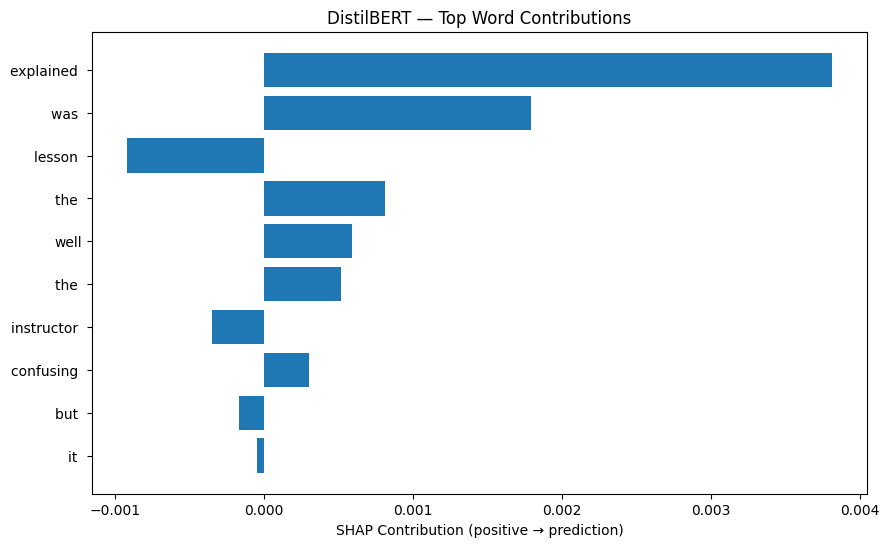

In [49]:
# === Extract tokens & SHAP values ===
vals = shap_values.values[0]        # shape: (num_tokens, num_classes)
tokens = shap_values.data[0]        # raw wordpiece tokens

# Select SHAP values for POSITIVE class (index 1)
word_shap = vals[:, 1]

# Remove empty tokens
clean_idx = [i for i, t in enumerate(tokens) if t.strip() != ""]
tokens = np.array([tokens[i] for i in clean_idx])
word_shap = np.array([word_shap[i] for i in clean_idx])

# === Get top N tokens ===
N = 15
idx = np.argsort(np.abs(word_shap))[::-1][:N]

top_tokens = tokens[idx]
top_scores = word_shap[idx]

# === Plot clean contribution diagram ===
plt.figure(figsize=(10, 6))
ypos = np.arange(len(top_tokens))

plt.barh(ypos, top_scores)
plt.yticks(ypos, top_tokens)
plt.xlabel("SHAP Contribution (positive → prediction)")
plt.title("DistilBERT — Top Word Contributions")
plt.gca().invert_yaxis()  # highest contribution on top

plt.show()